In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import math
import os
import numpy as np

In [4]:
fp = "/ptmp/mp002/ellis/lai/lai/LAI.1440.720.2007.nc"


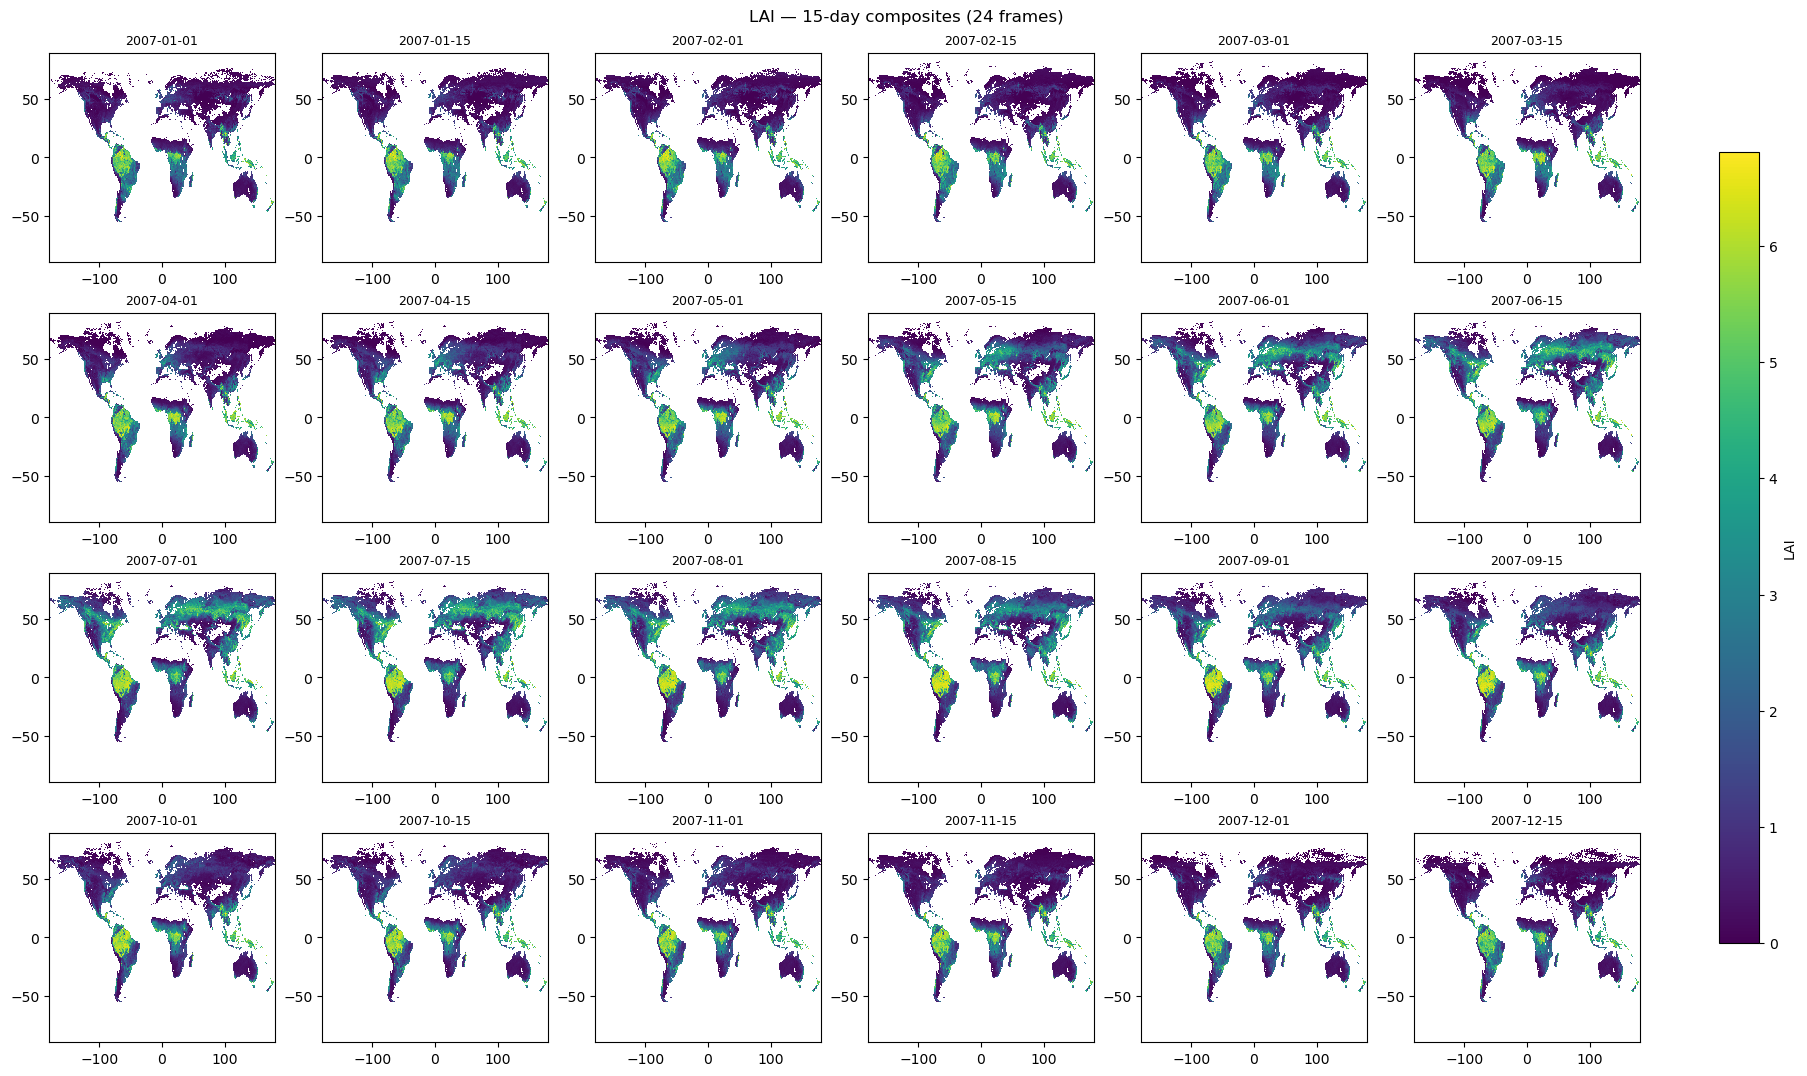

In [8]:
ds = xr.open_dataset(fp, engine="netcdf4")
var = next(v for v in ds.data_vars if ds[v].ndim >= 2)
da = ds[var]
assert "time" in da.dims

# figure out the latitude dim name
lat_name = "lat" if "lat" in da.coords else ("latitude" if "latitude" in da.coords else da.dims[-2])

# ensure latitude increases S→N (so N is up)
da = da.sortby(lat_name)  # <-- key line

n = da.sizes["time"]
ncols = 6
nrows = math.ceil(n / ncols)

vmin = float(da.min())
vmax = float(da.max())

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*2.6), constrained_layout=True)
axes = axes.ravel()

mappable = None
for i in range(n):
    ax = axes[i]
    img = da.isel(time=i).plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax)
    if mappable is None:
        mappable = img
    tval = da["time"].values[i]
    ax.set_title(str(tval)[:10], fontsize=9)
    ax.set_xlabel(""); ax.set_ylabel("")

for j in range(n, len(axes)):
    axes[j].axis("off")

cbar = fig.colorbar(mappable, ax=axes.tolist(), shrink=0.8)
cbar.set_label(var)

plt.suptitle(f"{var} — 15-day composites ({n} frames)", y=1.02)
plt.show() 

In [7]:

# --- Params ---
data_dir = "/ptmp/mp002/ellis/lai/lai"
fname_tmpl = "LAI.1440.720.{year}.nc"   # <-- year will be formatted here
years = range(1982, 2018)               # 1982..2017 inclusive
output_dir = "/ptmp/mp040/outputdir"     # <-- specify your own output directory
os.makedirs(output_dir, exist_ok=True)

In [ ]:
engine = "netcdf4"                      # change to "h5netcdf" if you prefer

# --- Helpers ---
def open_lai_year(year):
    fp = os.path.join(data_dir, fname_tmpl.format(year=year))
    ds = xr.open_dataset(fp, engine=engine)
    # pick first 2D/3D variable (or set var name explicitly if you know it)
    var = next(v for v in ds.data_vars if ds[v].ndim >= 2)
    da = ds[var]

    # ensure latitude increases S→N so North is "up"
    lat_name = "lat" if "lat" in da.coords else ("latitude" if "latitude" in da.coords else None)
    if lat_name is not None:
        da = da.sortby(lat_name)

    # make sure we have exactly 24 samples (15-day composites)
    if "time" not in da.dims:
        raise ValueError(f"No 'time' dimension in {fp}")
    if da.sizes["time"] != 24:
        raise ValueError(f"{fp} has {da.sizes['time']} time steps, expected 24.")

    # standardize dimension order to (time, lat, lon) if present
    # detect lon/lat dim names
    lon_name = "lon" if "lon" in da.coords else ("longitude" if "longitude" in da.coords else None)
    dims_order = ["time"]
    if lat_name: dims_order.append(lat_name)
    if lon_name: dims_order.append(lon_name)
    da = da.transpose(*dims_order, ...)

    return da, var, lat_name, lon_name

# --- Accumulate climatology (sum over years per sample index) ---
sum_samples = None
count_years = 0
var_name = None
lat_name = lon_name = None
lat_vals = lon_vals = None

for y in years:
    try:
        da, var_name, lat_name, lon_name = open_lai_year(y)
    except Exception as e:
        print(f"[WARN] Skipping {y}: {e}")
        continue

    # lazily load per-year (24, lat, lon) into memory once; float32 is enough for LAI
    da_vals = da.astype(np.float32).values

    if sum_samples is None:
        # initialize accumulator with zeros of shape (24, lat, lon)
        sum_samples = np.zeros_like(da_vals, dtype=np.float64)  # use float64 for stable summation
        # stash coords for the final DataArray
        if lat_name: lat_vals = da.coords[lat_name].values
        if lon_name: lon_vals = da.coords[lon_name].values

    sum_samples += da_vals
    count_years += 1

if count_years == 0:
    raise RuntimeError("No valid years processed; cannot compute climatology.")

# mean across years for each of the 24 samples
mean_samples = (sum_samples / count_years).astype(np.float32)

# --- Wrap back into xarray ---
coords = {"sample": np.arange(mean_samples.shape[0])}
dims = ["sample"]

if lat_name and lat_vals is not None:
    coords[lat_name] = lat_vals
    dims.append(lat_name)
if lon_name and lon_vals is not None:
    coords[lon_name] = lon_vals
    dims.append(lon_name)

clim = xr.DataArray(
    mean_samples,
    coords=coords,
    dims=dims,
    name=f"{var_name}_climatology"
)
clim.attrs.update(
    {
        "description": f"15-day (24-sample) climatology of {var_name}",
        "years_aggregated": f"{years.start}-{years.stop-1}",
        "samples_per_year": 24,
        "note": "sample=0 corresponds to the first 15-day composite of the year, ... sample=23 the last.",
    }
)

# Optional: save to NetCDF
out_nc = os.path.join(output_dir, f"{var_name}_climatology_1982_2017_24samples.nc")
clim.to_dataset(name=clim.name).to_netcdf(out_nc)
print(f"Saved climatology to: {out_nc}")


Saved climatology to: /ptmp/mp040/outputdir/LAI_climatology_1982_2017_24samples.nc


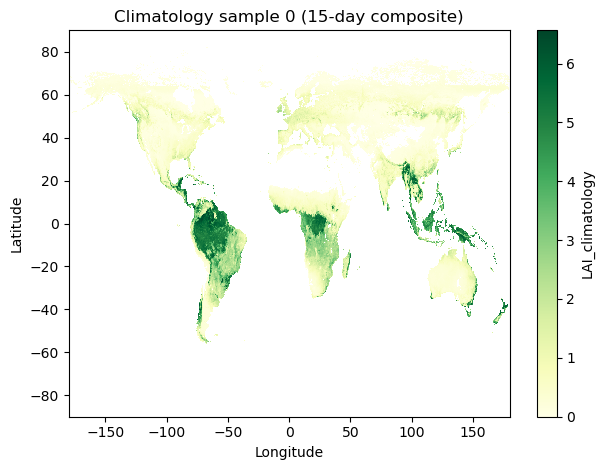

In [15]:
SAMPLE = 0  # 0..23 (0=Jan 1–15, 1=Jan 16–31, ...)

# Quick check plot for a chosen sample
import matplotlib.pyplot as plt

# ensure north is up (lat ascending)
clim = clim.sortby(lat_name)

clim.isel(sample=SAMPLE).plot(yincrease=True, cmap="YlGn")
plt.title(f"Climatology sample {SAMPLE} (15-day composite)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


Median valid frac — NH: 0.991, SH: 0.829


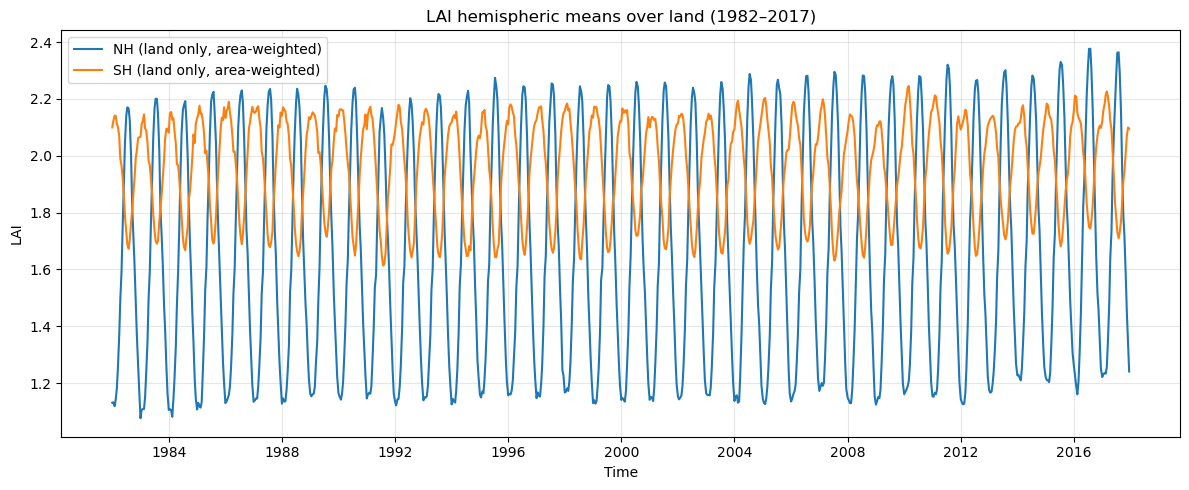

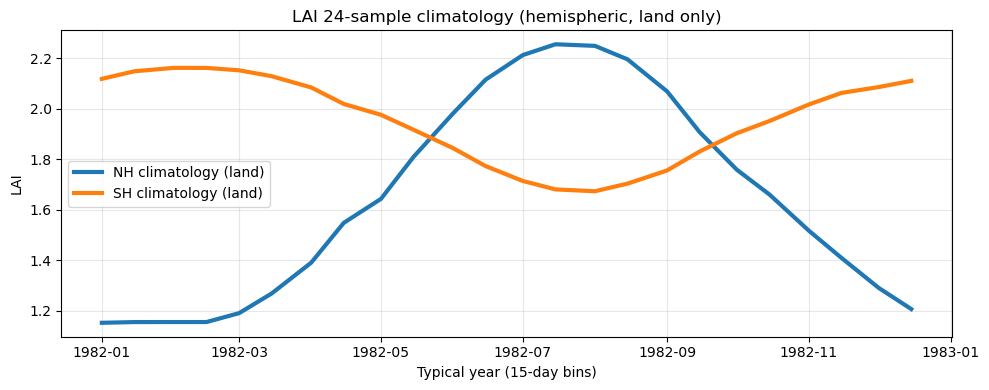

In [19]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os

# ---- user params ----
input_dir  = "/ptmp/mp002/ellis/lai/lai"
fname_tmpl = "LAI.1440.720.{year}.nc"
years      = range(1982, 2018)
engine     = "netcdf4"
# ---------------------

def open_lai_year(year):
    fp = os.path.join(input_dir, fname_tmpl.format(year=year))
    ds = xr.open_dataset(fp, engine=engine)
    var = next(v for v in ds.data_vars if ds[v].ndim >= 2)
    da = ds[var]

    # normalize missing: honor _FillValue if present; keep existing NaNs
    fv = da.attrs.get("_FillValue", None)
    if fv is not None:
        da = da.where(da != fv)

    # ensure latitude ascending (south→north)
    lat_name = "lat" if "lat" in da.coords else "latitude"
    lon_name = "lon" if "lon" in da.coords else "longitude"
    da = da.sortby(lat_name)

    # expect 24 half-monthly slices
    if da.sizes.get("time", None) != 24:
        raise ValueError(f"{fp} has {da.sizes.get('time')} time steps; expected 24")

    return da, var, lat_name, lon_name

def hemi_weighted_mean(da, lat_name, lon_name, hemisphere="+", return_valid_frac=False):
    """Area-weighted mean over hemisphere using cos(lat), ignoring NaNs."""
    sel = da[lat_name] > 0 if hemisphere == "+" else da[lat_name] < 0
    dah = da.sel({lat_name: sel})

    # zonal mean (ignores NaNs over ocean)
    zonal = dah.mean(dim=lon_name, skipna=True)

    # cos(lat) weights
    w = xr.apply_ufunc(np.cos, np.deg2rad(zonal[lat_name]))

    # Only count weights where data is finite
    w_eff = xr.where(np.isfinite(zonal), w, 0.0)

    num = (zonal * w_eff).sum(dim=lat_name)
    den = w_eff.sum(dim=lat_name)
    hemi_mean = num / den

    if not return_valid_frac:
        return hemi_mean

    # fraction of valid land (area-weighted) each timestep
    # compare to full hemisphere weights (same lat grid)
    w_full = w.where(np.isfinite(w), 0.0)
    frac_valid = den / w_full.sum(dim=lat_name)
    return hemi_mean, frac_valid

# ---- build time series across all years ----
times, nh_vals, sh_vals = [], [], []
nh_frac, sh_frac = [], []
var_name = lat_name = lon_name = None

for y in years:
    try:
        da, var_name, lat_name, lon_name = open_lai_year(y)
    except Exception as e:
        print(f"[WARN] {y}: {e}")
        continue

    nh, fnh = hemi_weighted_mean(da, lat_name, lon_name, "+", return_valid_frac=True)
    sh, fsh = hemi_weighted_mean(da, lat_name, lon_name, "-", return_valid_frac=True)

    times.append(da["time"].values)   # (24,)
    nh_vals.append(nh.values)         # (24,)
    sh_vals.append(sh.values)
    nh_frac.append(fnh.values)        # (24,) area-weighted valid fraction
    sh_frac.append(fsh.values)

# concat
time_all = np.concatenate(times)
nh_all   = np.concatenate(nh_vals)
sh_all   = np.concatenate(sh_vals)
nhf_all  = np.concatenate(nh_frac)
shf_all  = np.concatenate(sh_frac)

# quick sanity: typical valid area fractions (should be << 1 due to oceans)
print(f"Median valid frac — NH: {np.median(nhf_all):.3f}, SH: {np.median(shf_all):.3f}")

# plot seasonal cycles across all years
plt.figure(figsize=(12,5))
plt.plot(time_all, nh_all, label="NH (land only, area-weighted)")
plt.plot(time_all, sh_all, label="SH (land only, area-weighted)")
plt.title(f"{var_name} hemispheric means over land (1982–2017)")
plt.xlabel("Time"); plt.ylabel(var_name)
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# optional: 24-sample climatology (average across years)
if len(nh_vals) > 0:
    nh_clim = np.mean(np.stack(nh_vals, axis=0), axis=0)
    sh_clim = np.mean(np.stack(sh_vals, axis=0), axis=0)
    t0 = times[0]
    plt.figure(figsize=(10,4))
    plt.plot(t0, nh_clim, linewidth=3, label="NH climatology (land)")
    plt.plot(t0, sh_clim, linewidth=3, label="SH climatology (land)")
    plt.title(f"{var_name} 24-sample climatology (hemispheric, land only)")
    plt.xlabel("Typical year (15-day bins)"); plt.ylabel(var_name)
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

In [20]:
#!/usr/bin/env python3
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import math

# ----------------- USER PARAMS -----------------
input_dir    = "/ptmp/mp002/ellis/lai/lai"       # yearly LAI files
output_dir   = "/ptmp/mp040/outputdir/anom"      # where to write anomalies + PNGs
clim_path    = "//ptmp/mp040/outputdir/clim/LAI_climatology_1982_2017_24samples.nc"
fname_tmpl   = "LAI.1440.720.{year}.nc"
years        = range(1982, 2018)                 # 1982..2017 inclusive
engine       = "netcdf4"                         # or "h5netcdf"
png_dpi      = 160
# ------------------------------------------------

os.makedirs(output_dir, exist_ok=True)

# ---- load climatology mean ----
clim_ds = xr.open_dataset(clim_path)
clim_var = next(v for v in clim_ds.data_vars if clim_ds[v].ndim >= 2)  # e.g., "LAI_climatology"
clim_mean = clim_ds[clim_var]  # dims: sample, lat, lon (we created this earlier)

# detect coord names
lat_name = "lat" if "lat" in clim_mean.coords else "latitude"
lon_name = "lon" if "lon" in clim_mean.coords else "longitude"

# ensure north-up orientation
clim_mean = clim_mean.sortby(lat_name)

# ---- compute climatology std (once) from yearly files ----
def open_year(year):
    fp = os.path.join(input_dir, fname_tmpl.format(year=year))
    ds = xr.open_dataset(fp, engine=engine)
    var = next(v for v in ds.data_vars if ds[v].ndim >= 2)
    da = ds[var]
    # normalize missing
    fv = da.attrs.get("_FillValue", None)
    if fv is not None:
        da = da.where(da != fv)
    # ensure north-up
    da = da.sortby(lat_name)
    # add "sample" coord 0..23
    if da.sizes.get("time", None) != 24:
        raise ValueError(f"{fp} has {da.sizes.get('time')} time steps; expected 24")
    da = da.assign_coords(sample=("time", np.arange(da.sizes["time"])))
    return da, var

# stack all years along "year" to get std across years at each sample
year_arrays = []
var_name = None
for y in years:
    try:
        da_y, var_name = open_year(y)
    except Exception as e:
        print(f"[WARN] std base: skipping {y}: {e}")
        continue
    # align on sample,lat,lon (drop original time after assigning sample)
    year_arrays.append(da_y.groupby("sample").mean("time"))  # time is just index 0..23; mean is identity

if not year_arrays:
    raise RuntimeError("No valid years found to compute climatology std.")

# shape: (n_years, sample, lat, lon)
stacked = xr.concat(year_arrays, dim="year")
clim_std = stacked.std(dim="year", skipna=True).astype(np.float32)  # dims: sample, lat, lon
clim_std.name = f"{var_name}_climatology_std"

# Optional: prevent division by zero (very stable regions). Set tiny stds to NaN.
clim_std = clim_std.where(clim_std > 0)

# ---- helper: panel plot for 24 slices ----
def plot_24_panel(da24, title, out_png, vmin=None, vmax=None, cmap=None, yincrease=True):
    """da24 dims should be (sample, lat, lon)."""
    n = da24.sizes["sample"]
    ncols = 6
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3.0, nrows*2.6), constrained_layout=True)
    axes = axes.ravel()

    # global color limits if not given
    if vmin is None or vmax is None:
        vmin = float(da24.min().values)
        vmax = float(da24.max().values)

    # ensure consistent limits across panels
    mappable = None
    for i in range(n):
        ax = axes[i]
        img = da24.isel(sample=i).plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax,
                                       cmap=cmap, yincrease=yincrease)
        if mappable is None:
            mappable = img
        ax.set_title(f"S{i:02d}", fontsize=9)
        ax.set_xlabel(""); ax.set_ylabel("")
    for j in range(n, len(axes)):
        axes[j].axis("off")

    cbar = fig.colorbar(mappable, ax=axes.tolist(), shrink=0.85)
    cbar.set_label(da24.name if da24.name else "")

    plt.suptitle(title, y=1.02)
    plt.savefig(out_png, dpi=png_dpi, bbox_inches="tight")
    plt.close(fig)
    print(f"[PNG] {out_png}")

# ---- loop over years: save anomaly & z-score + PNGs ----
for y in years:
    try:
        da_y, _ = open_year(y)  # da_y dims: time, lat, lon + coord sample(time)
    except Exception as e:
        print(f"[WARN] year {y}: {e}")
        continue

    # match clim by sample
    by_sample = da_y.groupby("sample")
    anom = by_sample - clim_mean
    z = (by_sample - clim_mean) / clim_std

    # Clean metadata
    anom.name = f"{var_name}_anom"
    anom.attrs.update({
        "description": f"{var_name} anomaly vs 1982–2017 climatology (24-sample mean)",
        "anomaly_base_period": "1982–2017",
        "note": "sample=0..23 correspond to half-month bins within the year.",
    })

    z.name = f"{var_name}_z"
    z.attrs.update({
        "description": f"{var_name} standardized anomaly (z-score) vs 1982–2017 climatology",
        "anomaly_base_period": "1982–2017",
        "note": "z = (value - climatology_mean) / climatology_std; ocean stays NaN.",
    })

    # Save NetCDFs
    out_anom_nc = os.path.join(output_dir, f"{var_name}_anom_{y}.nc")
    out_z_nc    = os.path.join(output_dir, f"{var_name}_z_{y}.nc")
    anom.to_dataset(name=anom.name).to_netcdf(out_anom_nc)
    z.to_dataset(name=z.name).to_netcdf(out_z_nc)
    print(f"[OK] {out_anom_nc}")
    print(f"[OK] {out_z_nc}")

    # Build 24-panel PNGs
    # Convert from time to sample grid for plotting
    anom24 = anom.groupby("sample").mean("time")  # identity; just ensure dims (sample, lat, lon)
    z24    = z.groupby("sample").mean("time")

    # Choose symmetric color limits:
    # anomalies: robust symmetric limits from percentiles to avoid extreme outliers
    a_low, a_high = np.nanpercentile(anom24.values, [2, 98])
    a_abs = max(abs(a_low), abs(a_high))
    a_vmin, a_vmax = -a_abs, a_abs

    # z-scores: clamp to [-3, 3]
    z_vmin, z_vmax = -3.0, 3.0

    # Pick diverging colormaps (good for anomalies)
    plot_24_panel(anom24, f"{var_name} anomaly {y} (vs climatology)", 
                  os.path.join(output_dir, f"{var_name}_anom_{y}.png"),
                  vmin=a_vmin, vmax=a_vmax, cmap="RdBu_r", yincrease=True)

    plot_24_panel(z24, f"{var_name} z-score {y} (vs climatology std)", 
                  os.path.join(output_dir, f"{var_name}_z_{y}.png"),
                  vmin=z_vmin, vmax=z_vmax, cmap="RdYlBu_r", yincrease=True)

print("All done.")

/u/mp040/conda-envs/my_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[OK] /ptmp/mp040/outputdir/anom/LAI_anom_1982.nc
[OK] /ptmp/mp040/outputdir/anom/LAI_z_1982.nc
[PNG] /ptmp/mp040/outputdir/anom/LAI_anom_1982.png
[PNG] /ptmp/mp040/outputdir/anom/LAI_z_1982.png
[OK] /ptmp/mp040/outputdir/anom/LAI_anom_1983.nc
[OK] /ptmp/mp040/outputdir/anom/LAI_z_1983.nc
[PNG] /ptmp/mp040/outputdir/anom/LAI_anom_1983.png
[PNG] /ptmp/mp040/outputdir/anom/LAI_z_1983.png
[OK] /ptmp/mp040/outputdir/anom/LAI_anom_1984.nc
[OK] /ptmp/mp040/outputdir/anom/LAI_z_1984.nc
[PNG] /ptmp/mp040/outputdir/anom/LAI_anom_1984.png
[PNG] /ptmp/mp040/outputdir/anom/LAI_z_1984.png
[OK] /ptmp/mp040/outputdir/anom/LAI_anom_1985.nc
[OK] /ptmp/mp040/outputdir/anom/LAI_z_1985.nc
[PNG] /ptmp/mp040/outputdir/anom/LAI_anom_1985.png
[PNG] /ptmp/mp040/outputdir/anom/LAI_z_1985.png
[OK] /ptmp/mp040/outputdir/anom/LAI_anom_1986.nc
[OK] /ptmp/mp040/outputdir/anom/LAI_z_1986.nc
[PNG] /ptmp/mp040/outputdir/anom/LAI_anom_1986.png
[PNG] /ptmp/mp040/outputdir/anom/LAI_z_1986.png
[OK] /ptmp/mp040/outputdir/ano